In [27]:
import numpy as np
import theano 
import theano.tensor as T
import matplotlib.pyplot as plt
import math, os
from scipy.io import loadmat 
from sklearn.feature_extraction.image import PatchExtractor
from theano.compat.python2x import OrderedDict
from utils import tile_raster_images as tri
%matplotlib inline

In [2]:
data = loadmat("IMAGES.mat")

In [3]:
ims = np.transpose(data['IMAGES'], (2,0,1))

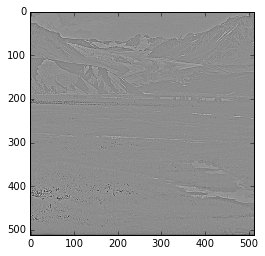

In [4]:
plt.imshow(ims[9], cmap = 'gray') 
plt.show()

In [5]:
shape = (8,8)
dim = np.prod(shape)
patches = PatchExtractor(shape, 64*64).transform(ims)
patches = patches.reshape(-1,dim).astype('float32')

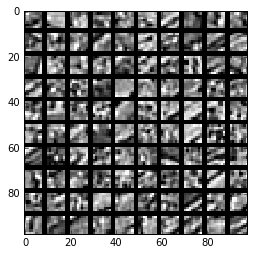

In [6]:
im = tri(patches[:100], shape, (10, 10), (2,2))
plt.imshow(im, cmap='gray', interpolation='nearest')

In [7]:
patches.shape

(40960, 64)

# starting theano

In [31]:
plot_folder = '/home/keniapina/plots/'
sparse_coding = True

if sparse_coding:
    sub = 'sc'
else:
    sub = 'mca'  

In [8]:
n_batch = 128
n_iter = 150
epochs = 50
n_neurons = 1*dim 

In [9]:
x = theano.shared(np.zeros((n_batch,dim)).astype('float32'))
w = np.random.randn(n_neurons,dim)
w_norm = np.sqrt(np.sum(w**2, axis=1, keepdims=True))
w = theano.shared((w/w_norm).astype('float32'))
a = theano.shared(np.zeros((n_batch,n_neurons)).astype('float32'))
x_batch = T.matrix() 

In [10]:
lam = .1 
eps_a = 10
eps_w = .1

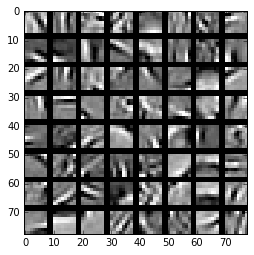

In [33]:
im = tri(w.get_value()[:64], shape, (8, 8), (2,2))
plt.imshow(im, cmap='gray', interpolation='nearest')
plt.savefig(os.path.join(plot_folder, sub, 'initial_image.png'))

In [12]:
if sparse_coding:
    x_hat = T.dot(a,w)
else:
    x_hat = 1.
recon = (.5*(x- x_hat)**2).sum(axis=1).mean()
coeff = abs(a).sum(axis=1).mean()
l0 = T.neq(a,0.).sum(axis=1).mean()
costfunction = recon+ lam*coeff 
grad_a = T.grad(costfunction,a) 
grad_w = T.grad(costfunction,w)

In [13]:
# first function will zero out the a's 
# step_a will begin gradiant descent on a
# step_w will begin gradient descent on w 
updates = OrderedDict()
updates[a] = 0.*a 
zero_a = theano.function([],[],updates = updates)

updates = OrderedDict()
updates[a] = a - eps_a*grad_a 
step_a = theano.function([],[costfunction,recon,coeff,l0],updates = updates)

updates = OrderedDict()
updates[x] = x_batch
update_x = theano.function([x_batch],[],updates = updates)

updates = OrderedDict()
wp = w - eps_w*grad_w
wp_norm = T.sqrt(T.sum(w**2, axis=1, keepdims=True))
updates[w] = wp/wp_norm
step_w = theano.function([],[costfunction],updates = updates) 

# Train the model

In [14]:
cost_array = np.zeros((epochs, n_iter))
recon_array = np.zeros((epochs, n_iter))
coeff_array = np.zeros((epochs,n_iter))
l0_array = np.zeros((epochs,n_iter))
hist_array = np.zeros((epochs, n_batch, n_neurons))

In [34]:
for kk in range(epochs):
    print kk
    for ii in range(int(math.floor(1.*patches.shape[0]/n_batch))):
        zero_a()
        update_x(patches[ii*n_batch : (ii+1)*n_batch])
        for jj in range(n_iter):
            cost, recon, coeff, l0 = step_a() 
            if ii == 0:
                cost_array[kk, jj] = cost
                recon_array[kk, jj] = recon
                coeff_array[kk, jj] = coeff
                l0_array[kk, jj] = l0
        if ii == 0:
            hist_array[kk] = a.get_value()
        #print cost
        step_w()
    plt.figure()
    im = tri(w.get_value()[:64], shape, (8, 8), (2,2))
    #increase 64 
    plt.imshow(im, cmap='gray', interpolation='nearest')

0


AttributeError: 'silent_list' object has no attribute 'shape'

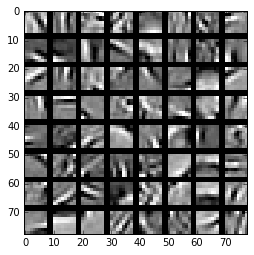

In [35]:
im = tri(w.get_value()[:64], shape, (8, 8), (2,2))
plt.imshow(im, cmap='gray', interpolation='nearest')
plt.savefig(os.path.join(plot_folder, sub, 'reconstructed_image.png'))

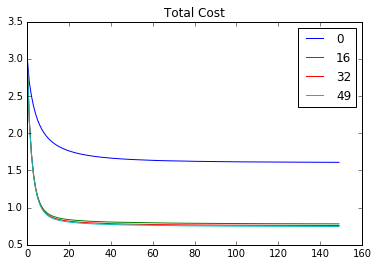

In [36]:
plot_epoch = np.linspace(0,epochs-1,4,dtype = int)
for idx in plot_epoch:
    plt.plot (np.arange(n_iter),cost_array[idx], label = idx)
plt.legend (loc = 'best')
plt.title('Total Cost')
plt.savefig(os.path.join(plot_folder, sub, 'total_cost.png'))

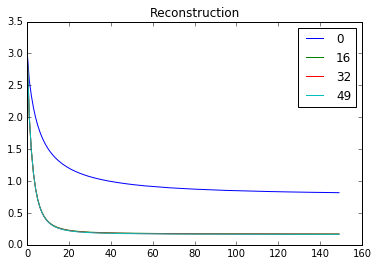

In [37]:
for idx in plot_epoch:
    plt.plot (np.arange(n_iter),recon_array[idx], label = idx)
plt.legend (loc = 'best')
plt.title('Reconstruction')
plt.savefig(os.path.join(plot_folder, sub, 'reconstruction.png'))

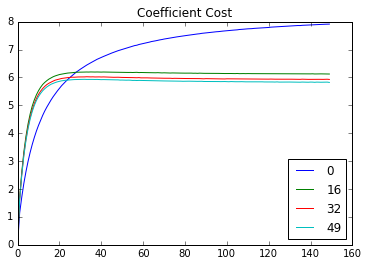

In [38]:
for idx in plot_epoch:
    plt.plot (np.arange(n_iter),coeff_array[idx], label = idx)
plt.legend (loc = 'best')
plt.title('Coefficient Cost')
plt.savefig(os.path.join(plot_folder, sub, 'coefficient_cost.png'))

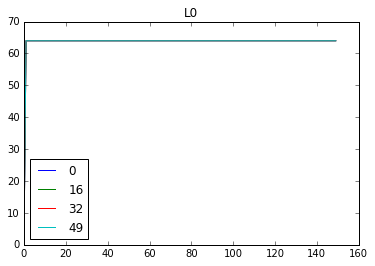

In [39]:
for idx in plot_epoch:
    plt.plot (np.arange(n_iter),l0_array[idx], label = idx)
plt.legend (loc = 'best')
plt.title('L0')
plt.savefig(os.path.join(plot_folder, sub, 'L0.png'))

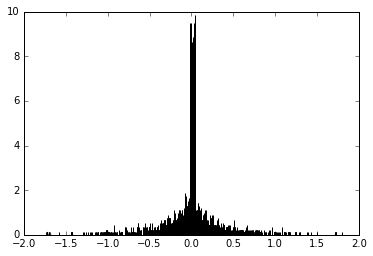

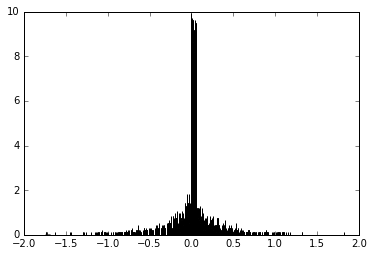

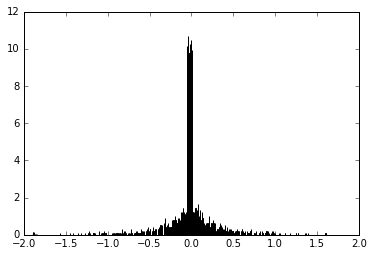

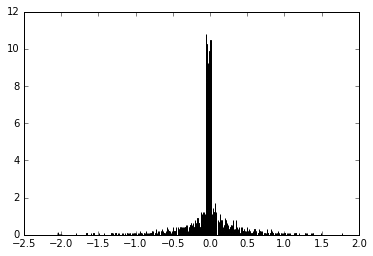

In [40]:
for idx in plot_epoch:
    # the histogram of the data
    plt.figure()
    n, bins, patches = plt.hist(hist_array[idx], 50, normed=1, facecolor='gray')
plt.savefig(os.path.join(plot_folder, sub, 'histogram.png'))

In [24]:
np.linalg.norm(w.get_value(), axis=1)

array([ 1.00010872,  1.00004292,  1.00007999,  1.00006461,  1.00035048,
        1.00008404,  1.00010037,  1.0001018 ,  1.0001806 ,  1.00016665,
        1.00006151,  1.00015783,  1.00007856,  1.00005531,  1.000103  ,
        1.0000422 ,  1.00021374,  1.00010288,  1.00013065,  1.00008988,
        1.00009227,  1.00013411,  1.00038838,  1.00016344,  1.00010622,
        1.00010419,  1.00021064,  1.00012434,  1.0000875 ,  1.00026357,
        1.00016594,  1.0000813 ,  1.00022411,  1.00012255,  1.000121  ,
        1.00005555,  1.00008357,  1.00014365,  1.00010979,  1.00008643,
        1.00011635,  1.0000577 ,  1.00015318,  1.00013292,  1.00008869,
        1.00016212,  1.00026917,  1.00021875,  1.00008106,  1.00023592,
        1.0001533 ,  1.00012445,  1.00014246,  1.00007498,  1.00024009,
        1.00002503,  1.00013316,  1.00039589,  1.00011861,  1.00007236,
        1.00012481,  1.00011349,  1.00012541,  1.00008941], dtype=float32)